# Train an agent to play Cliff Walking using Q-learning


[Gym](https://gym.openai.com/) is a toolkit for developing and comparing reinforcement algorithms. It contains several test problem (*environments*) that have a shared interface, allowing you to write general algorithms. 

Let's start with importing all necessary dependencies.

In [6]:
import gym
import numpy as np
import random
from enum import Enum

In [8]:
!pip install 'gymnasium[classic-control]'

## Description of the game

The Cliff Walking environment in Gymnasium (previously part of OpenAI Gym) is like this:

Imagine a grid — like a checkerboard — where you start in the bottom-left corner.
Your goal is to reach the bottom-right corner.
But! Between you and the goal, along the bottom row, is a cliff — a dangerous area.
If you step into the cliff, you "fall off," get a big negative reward (penalty), and you’re sent back to the start.
If you manage to walk safely around the cliff and reach the goal, you win.
More details:

Each move (up, down, left, right) gives a small penalty (like -1 reward) because they want to encourage you to find the fastest route.
Falling off the cliff gives a huge penalty (like -100).
The "safe" path is usually to move right across the second-to-last row, and only at the end move down carefully to the goal.

More info on: https://gymnasium.farama.org/environments/toy_text/cliff_walking/

In [11]:
env = gym.make("CliffWalking-v0")

## Initialize the Q-table 

Remember: 
- number of rows: number of states
- number of columns: number of actions
q-table: np array of dimension (states, actions)

add some things on how to make np arrays

In [15]:
state_space_size = env.observation_space.n
action_space_size = env.action_space.n

In [17]:
q_table = np.zeros((state_space_size, action_space_size))

In [19]:
q_table

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],


## Set the hyperparameters

In this section we will initialize the hyperparameters. 

The first one is the *discount factor*. This is a number in [0,1] indicating how much the agent cares about rewards in the future relative to those in the immediate future. 

In [24]:
discount_factor = 0.99

The second parameter is the *learning rate*. This is a number in [0,1] indicating how quickly the agent will adopt the new (learned) Q-value. 

In [27]:
learning_rate = 0.1

Finally we set the necessary parameters to deal with the trade-off between exploration and exploitation. We have to set
- *initial exploration rate*: upper bound for the exploration rate and initial exploration rate, we will use this to update the exploration rate
- *minimum exploration rate*: lower bound for the exploration rate, by setting it to a value greater than 0, we make sure there is always a probability for exploration
- *exploration rate*: probability that the agent will explore, will be updated after each episode, using exponential decay: 
$$N(t) = N_0 e^{-\lambda t}$$
where $N_0$ is the initial quantity, $N(t)$ is the quantity at time step $t$ and $\lambda$ is the rate of decay.
- *exploration rate decay*: how fast or slow does the exploration rate decay

In [30]:
initial_exploration_rate = 1
min_exploration_rate = 0.01
exploration_rate = 1
exploration_decay_rate = 0.001

We also set number of episodes and maximum number of steps per episode.

In [33]:
num_episodes = 10000
max_steps_per_episode = 100

## Train the agent

Store the total rewards for each episode. This is for diagnostics.

If an episode is succesfull this translate to reward 1 if not to reward 0, so we can use this array to check % of successes

In [38]:
rewards = np.zeros(num_episodes) 

In each episode:
1.   Reset environment
2.   For each step in the episode:
  - pick an action $a$ by generating a random float $r$ in $[0,1]$
    - if $r > \epsilon$ we choose the next action by exploitation
    - if $r \leq \epsilon$ we choose the next action by exploration
  - take action $a$ and observe reward $R$ and next state $s'$
  - update Q-table 
  $$ q(s,a) = q(s,a) + \alpha(R + \gamma max_{a'} q(s', a') - q(s,a)) $$
3. decrease exploration rate proportional to its current value, we will use exponential decay: 
$$N(t) = N_0 e^{-\lambda t}$$
where $N_0$ is the initial quantity and $N(t)$ is the quantity at time step $t$.



with 
- $\epsilon$ the exploration rate,
- $\lambda$ the exploration rate decay,
- $\alpha$ the learning rate and 
- $\gamma$ the discount factor.









In [41]:
for episode in range(num_episodes):
    state = env.reset()[0] # start with a clean slate
    reward_episode = 0 # keep track of total reward for this episode

    for step in range(max_steps_per_episode):
        # exploration or exploitation? -> we need to pick a random float in 0 and 1
        exploration_rate_treshold = random.uniform(0,1)
        if exploration_rate_treshold > exploration_rate:
            action = np.argmax(q_table[state]) #exploitation: look in row "state" which column "action" has the highest value
        else:
            action = env.action_space.sample() #exploration: random action

        # take a step in the environment: let's store the new state under a new name since we still need to use the old state
        new_state, reward, terminated, truncated , info = env.step(action)
        
        # terminated = True if environment terminates (eg. due to task completion, failure etc.)
        # truncated = True if episode truncates due to a time limit or a reason that is not defined as part of the task.
        done = truncated or terminated 

        # update q-table for current (state, action) pair
        q_table[state, action] += learning_rate *\
         (reward + discount_factor * np.max(q_table[new_state]) - q_table[state, action])

        # update state
        state = new_state
        # update reward episode
        reward_episode += reward # rewards[episode] += reward

        # check if episode ended
        if done:
            break

    # add reward current episode to rewards array
    rewards[episode] = reward_episode

    # update exploration rate
    exploration_rate = max(initial_exploration_rate * np.exp(- exploration_decay_rate * episode), min_exploration_rate)  

/opt/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Let's print the average reward per thousand episodes, this way we can get an idea about how rewards have changed over time.

In [44]:
rewards_per_thousand_episodes = np.split(rewards, num_episodes/1000)

In [46]:
count = 1000
for reward_group in rewards_per_thousand_episodes:
    print("after ", count, " episodes: ", np.average(reward_group))
    count+=1000

after  1000  episodes:  -566.707
after  2000  episodes:  -126.915
after  3000  episodes:  -48.311
after  4000  episodes:  -21.874
after  5000  episodes:  -18.055
after  6000  episodes:  -15.057
after  7000  episodes:  -15.601
after  8000  episodes:  -15.23
after  9000  episodes:  -16.646
after  10000  episodes:  -17.048


Let's also visualize the *learning curve* by plotting the moving average using a window length of 1000.

In [49]:
def moving_average(array, window):
    return np.convolve(array, np.ones(window), 'valid') / window

In [51]:
moving_average(rewards, 1000)

array([-566.707, -565.836, -566.32 , ...,  -17.05 ,  -17.048,  -17.048])

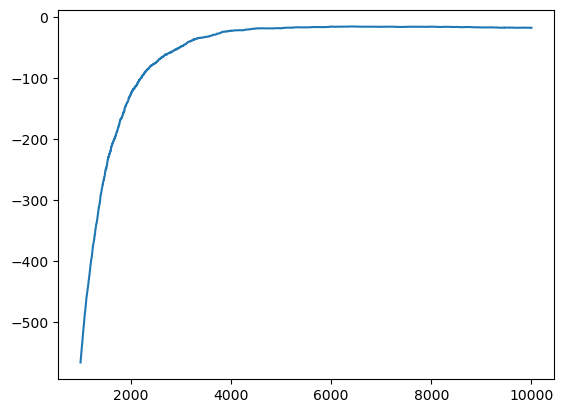

In [53]:
import matplotlib.pyplot as plt
plt.plot(np.arange(999, 10000), moving_average(rewards, 1000))
plt.show()

## Optimal policy

Let's print the q_table.

In [57]:
q_table

array([[ -13.52621724,  -13.0732419 ,  -13.07531888,  -13.21962343],
       [ -12.73354166,  -12.23922555,  -12.23980848,  -13.57077037],
       [ -12.17075106,  -11.35978053,  -11.35976357,  -12.93305571],
       [ -11.28961446,  -10.46552998,  -10.46555952,  -12.20210777],
       [ -10.4461629 ,   -9.56152798,   -9.56151628,  -11.29721431],
       [  -9.53529213,   -8.64815645,   -8.64816791,  -10.38447816],
       [  -8.62149862,   -7.72545702,   -7.72546039,   -9.54695647],
       [  -7.7022395 ,   -6.79343332,   -6.79343417,   -8.60677116],
       [  -6.78311613,   -5.85197141,   -5.85197141,   -7.67629567],
       [  -5.84014518,   -4.90099022,   -4.90099002,   -6.74300777],
       [  -4.85475422,   -3.94039763,   -3.9403976 ,   -5.83337763],
       [  -3.92602139,   -3.92225116,   -2.9701    ,   -4.84975266],
       [ -13.89652881,  -12.2478977 ,  -12.2478977 ,  -13.12486435],
       [ -13.10125095,  -11.36151283,  -11.36151283,  -13.12513059],
       [ -12.24232855,  -10.466174

Let's use the learned q_table to define the policy. Name the method `policy`.

In [60]:
def policy(state): # remove
    return np.argmax(q_table[state])

Let's use an Enum to print out nicely which action to take in which state. 

In [63]:
class Action(Enum):

    LEFT = 0
    DOWN = 1
    RIGHT = 2
    UP = 3

In [65]:
for state in range(state_space_size):
    print("state: ", state, " action to take: ", Action(policy(state)).name)

state:  0  action to take:  DOWN
state:  1  action to take:  DOWN
state:  2  action to take:  RIGHT
state:  3  action to take:  DOWN
state:  4  action to take:  RIGHT
state:  5  action to take:  DOWN
state:  6  action to take:  DOWN
state:  7  action to take:  DOWN
state:  8  action to take:  RIGHT
state:  9  action to take:  RIGHT
state:  10  action to take:  RIGHT
state:  11  action to take:  RIGHT
state:  12  action to take:  RIGHT
state:  13  action to take:  RIGHT
state:  14  action to take:  RIGHT
state:  15  action to take:  RIGHT
state:  16  action to take:  DOWN
state:  17  action to take:  RIGHT
state:  18  action to take:  RIGHT
state:  19  action to take:  DOWN
state:  20  action to take:  RIGHT
state:  21  action to take:  DOWN
state:  22  action to take:  DOWN
state:  23  action to take:  RIGHT
state:  24  action to take:  DOWN
state:  25  action to take:  DOWN
state:  26  action to take:  DOWN
state:  27  action to take:  DOWN
state:  28  action to take:  DOWN
state:  29

## Play Cliff Walking

Let's play Cliff Walking for `num_episodes` times and check how well our learned policy does on average. How does it compare to your handcoded policy?

In [69]:
rewards_test = np.zeros(num_episodes)

for episode in range(num_episodes):
    state = env.reset()[0]
    for step in range(max_steps_per_episode):
        state, reward, terminated, truncated, info = env.step(policy(state))
        rewards_test[episode] += reward
        done = truncated or terminated 
        if done:
            break

In [70]:
np.mean(rewards_test)

-13.0

If you want to play Cliff Walking ones and see how the environment evolves you can run the following cells.

In [74]:
from IPython.display import clear_output
import time

In [76]:
env = gym.make("CliffWalking-v0", render_mode="human")
state = env.reset()[0]
print(env.render())
for step in range(max_steps_per_episode):
    time.sleep(0.1)
    clear_output(wait=True)
    action = policy(state)       
    state, reward, terminated, truncated, info = env.step(action)
    env.render()  
    done = truncated or terminated 
    if done:
        break

if state == 47:
    print("\nReached the goal 🏆")
else:
    print("\nFell into the cliff ☠️")


Reached the goal 🏆


In [80]:
env.close()